# Introducción a la Ciencia de Datos: Tarea 2

Este notebook contiene el código de base para realizar la Tarea 2 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/).

**Se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.


## Cargar bibliotecas (dependencias)
Recuerde instalar los requerimientos (`requirements.txt`) en el mismo entorno donde está ejecutando este notebook (ver [README](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/)). Para la entrega 2 hay nuevas dependencias, por lo que es importante correr la siguiente celda.

In [2]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [3]:
import re
import os

from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import nltk
import matplotlib.patches as mpatches


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

## Lectura de Datos

In [4]:
# DataFrame con todos los discursos:
df_speeches = pd.read_csv('../data/us_2020_election_speeches.csv')
df_speeches

,speaker,title,text,date,location,type
0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,David Perdue: (00:01)\nHow great is it to be b...,"Oct 16, 2020","Macon, Georgia",Campaign Speech
1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Joe Biden: (00:00)\nHello, Michigan. Hi, how a...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech
2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,President Trump: (00:30)\nThank you. What a ni...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech
3,Joe Biden,Joe Biden ABC Town Hall Transcript October 15,"George Stephanopoulos: (00:41)\nHey, and welco...","Oct 15, 2020",ABC,Town Hall
4,Donald Trump,Donald Trump NBC Town Hall Transcript October 15,Savannah Guthrie: (03:50)\nIt’s nothing but no...,"Oct 15, 2020",NBC,Town Hall
...,...,...,...,...,...,...
264,Bernie Sanders,Bernie Sanders Speech Transcript: Sanders Spea...,Bernie Sanders: (00:00)\nJust want to take thi...,"Feb 6, 2020",Iowa,Campaign Speech
265,Democratic Candidates,Transcript: Speeches at the Iowa Caucuses – Be...,Bernie Sanders: (00:08)\nThank you. Thank you....,"Feb 4, 2020",Iowa,Campaign Speech
266,Donald Trump,Donal Trump Iowa Rally Transcript: Trump Holds...,Donald Trump: (00:24)\nI worked so hard for th...,"Jan 30, 2020","Des Moines, Iowa",Campaign Speech
267,Donald Trump,Donald Trump New Jersey Rally Speech Transcrip...,Donald Trump: (01:22)\nThank you. Thank you. I...,"Jan 28, 2020","Wildwood, New Jersey",Campaign Speech


In [ ]:
# Realizar la limpieza de los datos que crea pertinente. Se espera que usen la función clean_text() de la entrega anterior.

# Tome los 5 candidatos con más discursos
df_speeches_top_3 = df_speeches['speaker'].value_counts().head(3)  # Analizo el número de apariciones de cada candidato en mi DataFrame y me quedo con el top 5.
print(f"Top 3 candidatos: {df_speeches_top_3}")
print("---------------")

# DataFrame con los datos de los 3 candidatos con más discursos
df_speeches_top_3_df = df_speeches[df_speeches['speaker'].isin(df_speeches_top_3.index)] #Creo un DataFrame que posea únicamente los discursos de los 5 candidatos con más discursos.
df_speeches_top_3_df


Top 3 candidatos: speaker
Joe Biden       71
Donald Trump    53
Mike Pence      19
Name: count, dtype: int64
---------------


,speaker,title,text,date,location,type
1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Joe Biden: (00:00)\nHello, Michigan. Hi, how a...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech
2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,President Trump: (00:30)\nThank you. What a ni...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech
3,Joe Biden,Joe Biden ABC Town Hall Transcript October 15,"George Stephanopoulos: (00:41)\nHey, and welco...","Oct 15, 2020",ABC,Town Hall
4,Donald Trump,Donald Trump NBC Town Hall Transcript October 15,Savannah Guthrie: (03:50)\nIt’s nothing but no...,"Oct 15, 2020",NBC,Town Hall
5,Donald Trump,"Donald Trump Campaign Rally Greenville, NC Tra...",Donald Trump: (01:25)\nThank you very much. Th...,"Oct 15, 2020","Greenville, North Carolina",Campaign Speech
...,...,...,...,...,...,...
251,Donald Trump,"Donald Trump Phoenix, Arizona Rally Transcript","Donald Trump: (00:00)\nThank you very much, Ph...","Feb 20, 2020","Phoenix, Arizona",Campaign Speech
254,Joe Biden,"Joe Biden Reno, Nevada Town Hall Campaign Tran...",Joe Biden: (00:00)\n… that’s a higher rate tha...,"Feb 17, 2020","Reno, Nevada",Town Hall
257,Donald Trump,Donald Trump New Hampshire Rally Transcript Fe...,"Donald Trump: (02:41)\nHello, Manchester, and ...","Feb 10, 2020",New Hampshire,Campaign Speech
266,Donald Trump,Donal Trump Iowa Rally Transcript: Trump Holds...,Donald Trump: (00:24)\nI worked so hard for th...,"Jan 30, 2020","Des Moines, Iowa",Campaign Speech


In [7]:
# En los discursos se observa la presencia de diálogos entre los candidatos y agentes externos (entevistadores, multitudes, etc.) Dado que únicamente interesa lo que 
# efectivamente dice el candidato, se eliminará todo lo no dicho por él, así como todas las estampas de tiempo que correspondientes a las transcripciones.

#Dentro de los discursos, y en sus transcripciones, a los candidatos se los menciona de distintas formas. Nos interesa quedarnos con todo lo que dice el candidato, sea como sea 
# que se lo nombre. 
aliases = {
    "Donald Trump": ["Donald Trump", "President Trump", "Mr. Trump", "President Donald J. Trump"],
    "Joe Biden": ["Joe Biden", "President Biden", "Mr. Biden"],
    "Mike Pence": ["Mike Pence", "Vice President Pence", "Mr. Pence"],
    "Kamala Harris": ["Kamala Harris", "Senator Harris", "Mrs. Harris"],
    "Bernie Sanders": ["Bernie Sanders", "Senator Sanders", "Mr. Sanders"]
}

def extract_candidate_speech(text, candidate):
    valid_aliases = aliases.get(candidate, [])

    # Captura encabezados como "Nombre del candidato: (HH:MM:SS)" o "(MM:SS)"
    pattern = re.compile(r"^(.*?):\s*\((\d{1,2}:)?\d{1,2}:\d{2}\)\s*\n", re.MULTILINE)

    matches = list(pattern.finditer(text))  # busco todas las coincidencias de pattern en el texto. finditer analiza el texto buscando las coincidencias y devuelve la posición en el texto donde se encuentra el pattern.
    speeches = []

    for i, match in enumerate(matches):  #Itero en todas las coincidencias
        speaker = match.group(1).strip() # Devuelve la persona que habla (candidato o audiencia o cualquier otra persona que habló.)
        start = match.end() #Devuelve el índice del primer caracter posterior al pattern. 
        end = matches[i + 1].start() if i + 1 < len(matches) else len(text) #Devuelve el índice del primer caracter previo al sigueinte pattern.
        speech_text = text[start:end].strip()  #Se queda con el texto de los discursos (todo lo posterior a los encabezados)
        
        if speaker in valid_aliases: # A partir de aqui me quedo solo con el texto de los candidatos.
            # Elimina etiquetas como [inaudible 00:06:17], [crosstalk 01:02:33], etc.
            clean_speech = re.sub(r"\[[^\]]*\d{1,2}:\d{2}(?::\d{2})?\]", "", speech_text) # Quito ciertas estructuras con la función re.sub()
            speeches.append(clean_speech.strip())

    return "\n".join(speeches) # Devuelvo las partes del discurso dichas por el candidato, separadas por párrafos (\n).

# Aplicamos la limpieza de partes del discurso que no nos interesan. La aplicación se hace sobre cada fila del DataFrame.
df_speeches_top_3_df["pre_processed_text"] = df_speeches_top_3_df.apply(
    lambda row: extract_candidate_speech(row["text"], row["speaker"]),
    axis=1
)


C:\Users\matoi\AppData\Local\Temp\ipykernel_4864\184230946.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_3_df["pre_processed_text"] = df_speeches_top_3_df.apply(


In [8]:
import re

def expand_contractions(text):
    contractions = {
        r"\bcan’t\b": "cannot",   #con el r indico que es una cadena cruda, por ende el \b me separa la palabra can't de otras palabras que la contengan.
        r"\bwon’t\b": "will not",
        r"\bit’s\b": "it is",
        r"\bi’m\b": "i am",
        r"\bi’ve\b": "i have",
        r"\bi’d\b": "i would",
        r"\bi’ll\b": "i will",
        r"\byou’re\b": "you are",
        r"\byou’ve\b": "you have",
        r"\byou’d\b": "you would",
        r"\byou’ll\b": "you will",
        r"\bhe’s\b": "he is",
        r"\bshe’s\b": "she is",
        r"\bthey’re\b": "they are",
        r"\bwe’re\b": "we are",
        r"\bdon’t\b": "do not",
        r"\bdidn’t\b": "did not",
        r"\bdoesn’t\b": "does not",
        r"\bwasn’t\b": "was not",
        r"\bweren’t\b": "were not",
        r"\bcouldn’t\b": "could not",
        r"\bshouldn’t\b": "should not",
        r"\bwouldn’t\b": "would not",
        r"\bthat’s\b": "that is",
        r"\bthere’s\b": "there is",
        r"\bwhat’s\b": "what is",
        r"\bwho’s\b": "who is",
        r"\blet’s\b": "let us",
        r"\bisn’t\b": "is not",
        r"\baren’t\b": "are not",
        r"\bgonna\b": "going to",
        r"\bwanna\b": "want to",
        r"\bgotta\b": "got to"
    }
    for pattern, repl in contractions.items():
        text = re.sub(pattern, repl, text)
    return text

def clean_text(df, column_name):
    
    # Eliminar primeras palabras hasta el primer "\n"
    result = df[column_name].str.replace(r"^[^\n]*\n", "", regex=True)
    
    # Convertir todo a minúsculas
    result = result.str.lower()
    
    # Expandir contracciones
    result = result.apply(expand_contractions)

    # Reemplazar signos de puntuación faltantes
    for punc in ["[", "]", "\n", ",", ":", "?", "(", ")", "!", ".", "...",";", "¿", "¡", "“", "”", '"', "'", "‘", "’", "{", "}", "%","$","0","1","-","/","2","22","3","4","5","6","7","8","9"]: # agregue: "%" "(", ")", "!", ".", ";", "¿", "¡", "“", "”", '"', "'", "‘", "’", "{", "}"
        result = result.str.replace(punc, " ")

    # Reemplazar saltos de línea por espacios (por si quedaron después del paso 1)
    result = result.str.replace(r"\n", " ", regex=True)

    # Eliminar múltiples espacios con uno solo (normaliza frases)
    result = result.str.replace(r"\s+", " ", regex=True)

    # Eliminar espacios al inicio o final
    result = result.str.strip()

    return result

# Crear una nueva columna CleanText a partir de 'text'
df_speeches_top_3_df.loc[:, "CleanText"] = clean_text(df_speeches_top_3_df, "pre_processed_text")
df_speeches_top_3_df.loc[:, "CleanText"]

C:\Users\matoi\AppData\Local\Temp\ipykernel_4864\3011247908.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_3_df.loc[:, "CleanText"] = clean_text(df_speeches_top_3_df, "pre_processed_text")


1      there is not a better governor in the united s...
2      thank you very much please we are going to be ...
3      okay i know it well well first of all going ba...
4      it is great to be back in my home state florid...
5      great state it is fantastic to be back in nort...
                             ...                        
251    it is great being here in the great state of a...
254    now look going on too much let me conclude and...
257    but we have more in this arena and outside of ...
266    i mean i do not even know i just saw new york ...
267    together we are achieving historic victories f...
Name: CleanText, Length: 143, dtype: object

In [10]:
df_speeches_top_3_df

,speaker,title,text,date,location,type,pre_processed_text,CleanText
1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Joe Biden: (00:00)\nHello, Michigan. Hi, how a...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech,"Hello, Michigan. Hi, how are you? What’s your ...",there is not a better governor in the united s...
2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,President Trump: (00:30)\nThank you. What a ni...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech,Thank you. What a nice group. Thank you very m...,thank you very much please we are going to be ...
3,Joe Biden,Joe Biden ABC Town Hall Transcript October 15,"George Stephanopoulos: (00:41)\nHey, and welco...","Oct 15, 2020",ABC,Town Hall,Good to be with you.\nOkay.\nI know it well.\n...,okay i know it well well first of all going ba...
4,Donald Trump,Donald Trump NBC Town Hall Transcript October 15,Savannah Guthrie: (03:50)\nIt’s nothing but no...,"Oct 15, 2020",NBC,Town Hall,"I’m feeling great, I don’t know about you. How...",it is great to be back in my home state florid...
5,Donald Trump,"Donald Trump Campaign Rally Greenville, NC Tra...",Donald Trump: (01:25)\nThank you very much. Th...,"Oct 15, 2020","Greenville, North Carolina",Campaign Speech,"Thank you very much. Thank you. Let’s see, it’...",great state it is fantastic to be back in nort...
...,...,...,...,...,...,...,...,...
251,Donald Trump,"Donald Trump Phoenix, Arizona Rally Transcript","Donald Trump: (00:00)\nThank you very much, Ph...","Feb 20, 2020","Phoenix, Arizona",Campaign Speech,"Thank you very much, Phoenix. We love to be ba...",it is great being here in the great state of a...
254,Joe Biden,"Joe Biden Reno, Nevada Town Hall Campaign Tran...",Joe Biden: (00:00)\n… that’s a higher rate tha...,"Feb 17, 2020","Reno, Nevada",Town Hall,… that’s a higher rate than these guys pay for...,now look going on too much let me conclude and...
257,Donald Trump,Donald Trump New Hampshire Rally Transcript Fe...,"Donald Trump: (02:41)\nHello, Manchester, and ...","Feb 10, 2020",New Hampshire,Campaign Speech,"Hello, Manchester, and I am thrilled to be in ...",but we have more in this arena and outside of ...
266,Donald Trump,Donal Trump Iowa Rally Transcript: Trump Holds...,Donald Trump: (00:24)\nI worked so hard for th...,"Jan 30, 2020","Des Moines, Iowa",Campaign Speech,I worked so hard for this state. I worked so h...,i mean i do not even know i just saw new york ...


## Parte 1: Dataset y representación numérica de texto

In [13]:
# 1: Separar 30% del conjunto para test. Al resto lo llamamos "dev" (desarrollo).
X = df_speeches_top_3_df["CleanText"].to_numpy()  # to_numpy convierte la columna del dataframe a NumPy ndarray 
y = df_speeches_top_3_df["speaker"].to_numpy()

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)  # stratify=y asegura que la proporción de clases se mantenga en ambos conjuntos.

print(f"Tamaños de los conjuntos: {X_dev.shape}, {X_test.shape}")
#   Hay 143 discursos de los 3 candidatos con más discursos.

Tamaños de los conjuntos: (100,), (43,)


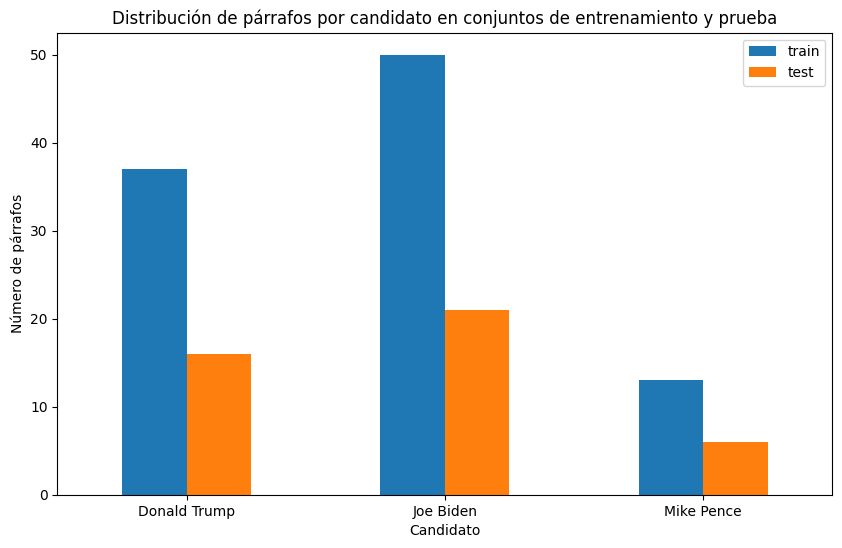

In [14]:
# Lista de candidatos
candidatos = df_speeches_top_3_df["speaker"].unique()

# Crear una paleta de colores fija basada en Set2
base_palette = sns.color_palette("Set1", n_colors=len(candidatos))
custom_palette = dict(zip(candidatos, base_palette))

# 2: Visualización de la proporción de cada candidato por conjunto
# Visualización para verificar el balance de párrafos
# Quiero asegurar que y_train y y_test sean Series
y_dev = pd.Series(y_dev)
y_test = pd.Series(y_test)

# Contar el número de párrafos por personaje en los conjuntos de entrenamiento y prueba
train_counts = y_dev.value_counts()
test_counts = y_test.value_counts()

# DataFrame para facilitar la visualización
counts_df = pd.DataFrame({'train': train_counts, 'test': test_counts}).sort_index()

# Visualización
counts_df.plot(kind='bar', figsize=(10, 6))
plt.title('Distribución de párrafos por candidato en conjuntos de entrenamiento y prueba')
plt.xlabel('Candidato')
plt.ylabel('Número de párrafos')
plt.xticks(rotation=0)

# Guardar la figura antes de mostrarla
#plt.savefig('./Parte_1/Fig/distribucion_personajes.png')

plt.show()


In [15]:
# 3: Transforme el texto del conjunto de entrenamiento a la representación numérica (features) de conteo de palabras o bag of words.
# Crear el vectorizador de conteo
vectorizer = CountVectorizer() # Aquí se puede ajustar el vectorizador según las necesidades, como agregar stopwords, n-grams, etc. El vectorizer es una herramienta que transforma texto en números

# Ajustar y transformar el conjunto de entrenamiento
X_dev_counts = vectorizer.fit_transform(X_dev)

# Transformar el conjunto de prueba
X_test_counts = vectorizer.transform(X_test) #La salida es una matriz dispersa (sparse matrix) que representa la frecuencia de palabras en los discursos de los candidatos.

# Verificar las dimensiones de la matriz de características
print(f"Dimensiones de X_dev_counts: {X_dev_counts.shape}")

Dimensiones de X_dev_counts: (100, 10905)


In [16]:
# PARTE C: EJEMPLO DE BAG OF WORDS (BoW)
texts = [
    "La rambla de Montevideo",
    "Aguante la rambla la",
    "Ayer me robaron el celular",
]

# Inicializar el CountVectorizer
vectorizer_2 = CountVectorizer()

# Ajustar y transformar los textos
X_train_counts_ej = vectorizer_2.fit_transform(texts)

# Convertir a DataFrame para visualizar mejor
df_counts = pd.DataFrame(X_train_counts_ej.toarray(), columns=vectorizer_2.get_feature_names_out())
print(df_counts)

# Visualizar detalles
print("Vocabulario:", vectorizer_2.vocabulary_)
print("Tamaño de la matriz resultante:", X_train_counts_ej.shape)
print("Matriz de conteo de palabras (BoW):\n", df_counts)

# Ejemplo de cómo se vería la matriz dispersa
print("Matriz dispersa:\n", X_train_counts_ej)

   aguante  ayer  celular  de  el  la  me  montevideo  rambla  robaron
0        0     0        0   1   0   1   0           1       1        0
1        1     0        0   0   0   2   0           0       1        0
2        0     1        1   0   1   0   1           0       0        1
Vocabulario: {'la': 5, 'rambla': 8, 'de': 3, 'montevideo': 7, 'aguante': 0, 'ayer': 1, 'me': 6, 'robaron': 9, 'el': 4, 'celular': 2}
Tamaño de la matriz resultante: (3, 10)
Matriz de conteo de palabras (BoW):
    aguante  ayer  celular  de  el  la  me  montevideo  rambla  robaron
0        0     0        0   1   0   1   0           1       1        0
1        1     0        0   0   0   2   0           0       1        0
2        0     1        1   0   1   0   1           0       0        1
Matriz dispersa:
 <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12 stored elements and shape (3, 10)>
  Coords	Values
  (0, 5)	1
  (0, 8)	1
  (0, 3)	1
  (0, 7)	1
  (1, 5)	2
  (1, 8)	1
  (1, 0)	1
  (2, 1)	1
  

Dimensiones de X_dev_tfidf: (100, 10905)
Términos con mayor TF-IDF en el conjunto de entrenamiento:
we
is
and
to
the


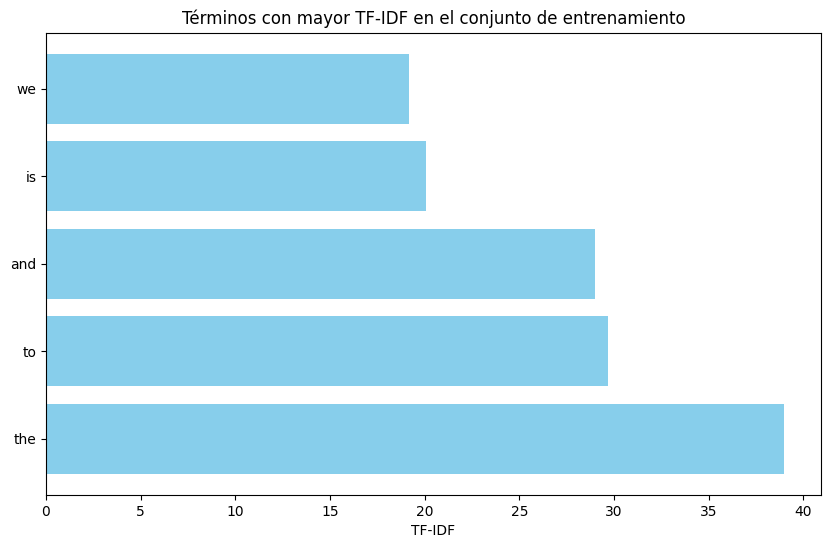

In [ ]:
# 4: Obtenga la representación numérica Term Frequency - Inverse Document Frequency.
# Crear el transformador TF-IDF
tfidf_transformer = TfidfTransformer(use_idf=False)  # use_idf=False para usar solo la frecuencia de término (TF)

# Ajustar y transformar el conjunto de entrenamiento
X_dev_tfidf = tfidf_transformer.fit_transform(X_dev_counts)

# Transformar el conjunto de prueba
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Verificar las dimensiones de la matriz TF-IDF
print(f"Dimensiones de X_dev_tfidf: {X_dev_tfidf.shape}")

# Visualizar los primeros 5 términos con mayor TF-IDF en el conjunto de entrenamiento
feature_names = vectorizer.get_feature_names_out()
# Obtener los índices de los términos con mayor TF-IDF
top_n = 5
top_indices = np.argsort(X_dev_tfidf.toarray().sum(axis=0))[-top_n:]  # Sumo las filas para obtener el TF-IDF total de cada término
top_terms = feature_names[top_indices]
print("Términos con mayor TF-IDF en el conjunto de entrenamiento:")
for term in top_terms:
    print(term) 
# Visualizar los términos con mayor TF-IDF
plt.figure(figsize=(10, 6))
plt.barh(top_terms, X_dev_tfidf.toarray().sum(axis=0)[top_indices], color='skyblue')
plt.xlabel('TF-IDF')
plt.title('Términos con mayor TF en el conjunto de entrenamiento')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar el término con mayor TF-IDF en la parte superior
plt.show()



Dimensiones de X_dev_pca: (100, 2)


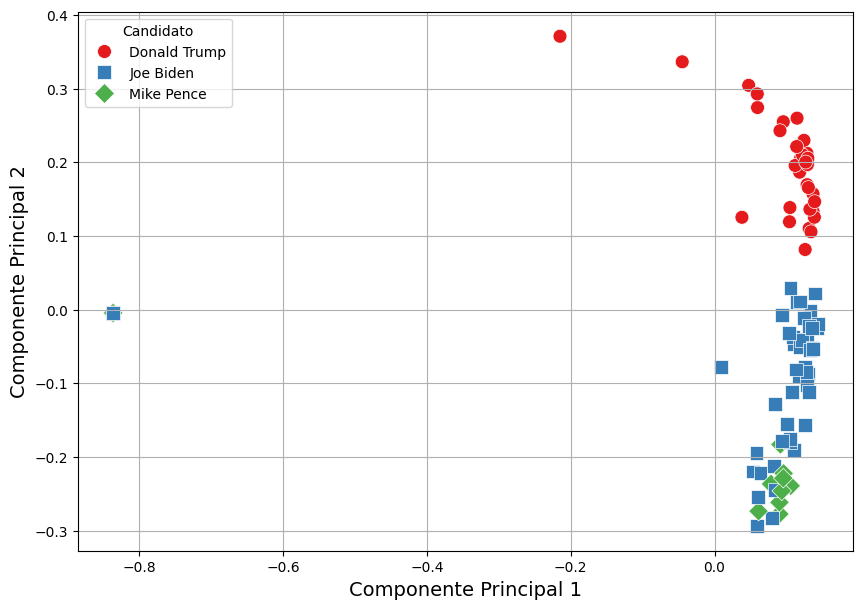

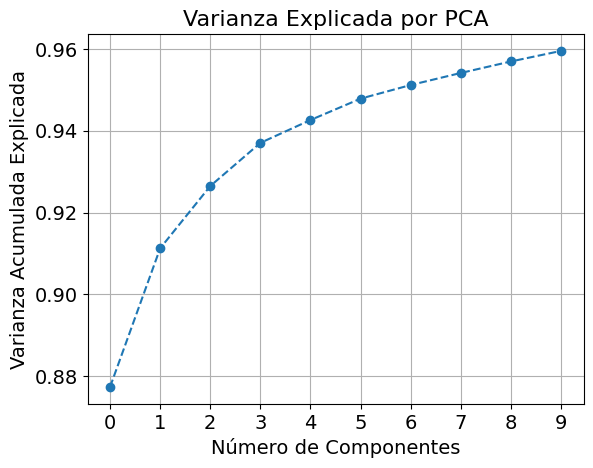

In [25]:
# 5: Muestre en un mapa el conjunto de entrenamiento, utilizando las dos primeras componentes PCA sobre los vectores de tf-idf.

# ---PRIMERA ITERACION: IDF FALSO Y SIN FILTRAR STOPWORDS---

# Aplicar PCA para reducir la dimensionalidad a 2 componentes
pca = PCA(n_components=2)
X_dev_pca = pca.fit_transform(X_dev_tfidf.toarray())  # Convertimos la matriz dispersa a un array denso para PCA

# Verificar las dimensiones de la matriz PCA
print(f"Dimensiones de X_dev_pca: {X_dev_pca.shape}")

# Crear un DataFrame para facilitar la visualización
df_pca = pd.DataFrame(X_dev_pca, columns=['Component 1', 'Component 2'])

# Agregar la columna de etiquetas
df_pca['Speaker'] = y_dev

# Visualizar los datos en un mapa de dispersión
# Crear DataFrame para graficar
df_plot = pd.DataFrame({
    'PC1': X_dev_pca[:, 0],
    'PC2': X_dev_pca[:, 1],
    'Candidato': df_pca["Speaker"]
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="Candidato",palette="Set1", style="Candidato", markers=["o", "s", "D"], s=100, edgecolor='w', linewidth=0.5)
plt.xlabel("Componente Principal 1",fontsize=14)
plt.ylabel("Componente Principal 2",fontsize=14)
plt.grid(True)
plt.show()


# Visualización que permita entender cómo varía la varianza explicada a medida que se agregan componentes (e.g: hasta 10 componentes).

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_dev_counts.toarray())

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Número de Componentes",fontsize=14)
plt.xticks(np.arange(0, 10, 1), fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Varianza Acumulada Explicada",fontsize=14)
plt.title("Varianza Explicada por PCA",fontsize=16)
plt.grid(True)
plt.show()


Dimensiones de X_dev_counts: (100, 10905)
Dimensiones de X_dev_tfidf: (100, 28656)
Primeros 5 términos del vocabulario: ['abandon' 'abandoned' 'abc' 'abc terrible' 'abc washington']
Dimensiones de X_dev_pca: (100, 2)


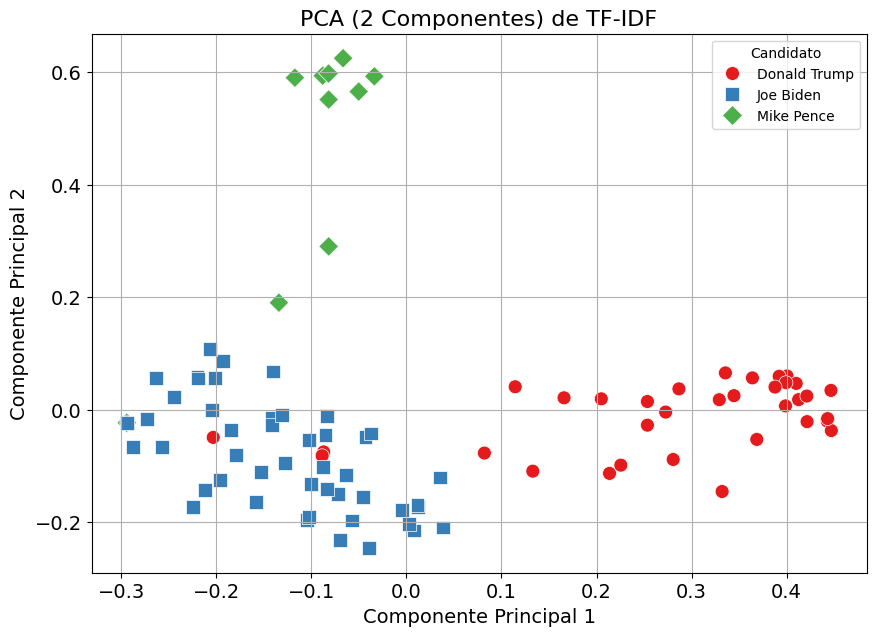

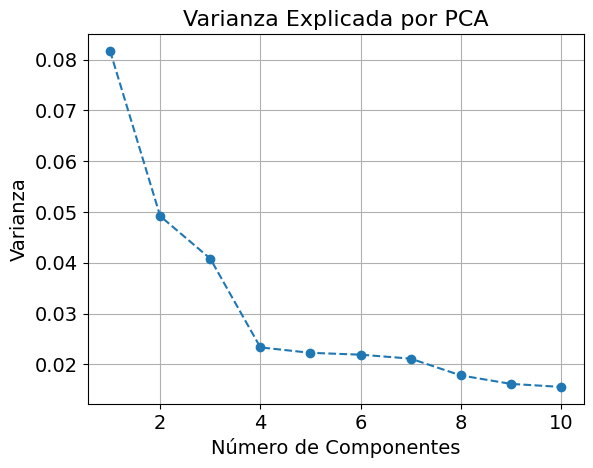

In [33]:
####### AFINO EL ANÁLISIS SACANDO STOPWORDS Y CON IDF VERDADERO #######

# Crear el vectorizador de conteo
vectorizer_3 = CountVectorizer(stop_words="english", ngram_range=(1, 2), min_df=2)
# Ajustar y transformar el conjunto de entrenamiento
X_dev_counts_2 = vectorizer_3.fit_transform(X_dev)
# Transformar el conjunto de prueba
X_test_counts_2 = vectorizer_3.transform(X_test) #La salida es una matriz dispersa (sparse matrix) que representa la frecuencia de palabras en los discursos de los candidatos.
# Verificar las dimensiones de la matriz de características
print(f"Dimensiones de X_dev_counts: {X_dev_counts.shape}")


# Crear el transformador TF-IDF: PONGO IDF=TRUE
tfidf_transformer_2 = TfidfTransformer(use_idf=True)  # use_idf=True indica que se utilizará el IDF en el cálculo del TF-IDF
# Ajustar y transformar el conjunto de entrenamiento
X_dev_tfidf_2 = tfidf_transformer_2.fit_transform(X_dev_counts_2)
# Transformar el conjunto de prueba
X_test_tfidf_2 = tfidf_transformer_2.transform(X_test_counts_2)
# Verificar las dimensiones de la matriz TF-IDF
print(f"Dimensiones de X_dev_tfidf: {X_dev_tfidf_2.shape}")
# Visualizar los primeros 5 términos del vocabulario
print("Primeros 5 términos del vocabulario:", vectorizer_3.get_feature_names_out()[:5])


# Aplicar PCA para reducir la dimensionalidad a 2 componentes---PRIMERA ITERACION: IDF VERDADER Y FILTRANDO STOPWORDS
pca = PCA(n_components=2)
X_dev_pca_2 = pca.fit_transform(X_dev_tfidf_2.toarray())  # Convertimos la matriz dispersa a un array denso para PCA
# Verificar las dimensiones de la matriz PCA
print(f"Dimensiones de X_dev_pca: {X_dev_pca_2.shape}")
# Crear un DataFrame para facilitar la visualización
df_pca_2 = pd.DataFrame(X_dev_pca_2, columns=['Component 1', 'Component 2'])
# Agregar la columna de etiquetas
df_pca_2['Speaker'] = y_dev
# Visualizar los datos en un mapa de dispersión
# Crear DataFrame para graficar
df_plot_2 = pd.DataFrame({
    'PC1': X_dev_pca_2[:, 0],
    'PC2': X_dev_pca_2[:, 1],
    'Candidato': df_pca_2["Speaker"]
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot_2, x="PC1", y="PC2", hue="Candidato", palette="Set1", style="Candidato", markers=["o", "s", "D"], s=100, edgecolor='w', linewidth=0.5)
plt.title("PCA (2 Componentes) de TF-IDF",fontsize=16)
plt.xlabel("Componente Principal 1",fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.ylabel("Componente Principal 2",fontsize=14)
plt.grid(True)
plt.show()


# visualización que permita entender cómo varía la varianza explicada a medida que se agregan componentes (e.g: hasta 10 componentes).

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_dev_tfidf_2.toarray())

plt.plot(range(1, 11), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel("Número de Componentes",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Varianza",fontsize=14)
plt.title("Varianza Explicada por PCA",fontsize=16)
plt.grid(True)
plt.show()



## Parte 2: Entrenamiento y Evaluación de Modelos


Accuracy del modelo Naive Bayes: 0.77


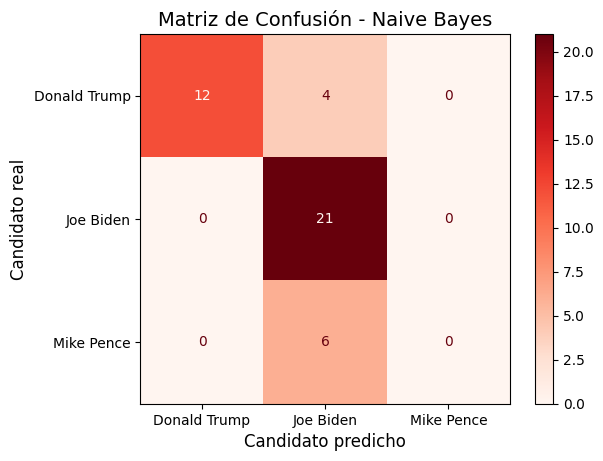

Precision y Recall por Candidato:       Candidato  Precision  Recall
0  Donald Trump   1.000000    0.75
1     Joe Biden   0.677419    1.00
2    Mike Pence   0.000000    0.00


c:\Users\matoi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [34]:
# TRABAJAMOS CON LOS TF-IDF

# 1: Entrene el modelo Multinomial Naive Bayes, luego utilícelo para predecir sobre el conjunto de test, y reporte el valor de accuracy y la matriz de confusión. Reporte el valor de precision y recall para cada candidato. 
# Calcular matriz de confusión Sugerencia: utilice el método from_predictions de ConfusionMatrixDisplay para realizar la matriz.

# Entrenar el modelo Multinomial Naive Bayes
nb_model = MultinomialNB()
# Ajustar el modelo al conjunto de entrenamiento
nb_model.fit(X_dev_tfidf_2, y_dev)
# Predecir sobre el conjunto de prueba
y_pred = nb_model.predict(X_test_tfidf_2)
# Calcular el accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo Naive Bayes: {accuracy:.2f}")
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)
# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot(cmap=plt.cm.Reds, )
plt.title("Matriz de Confusión - Naive Bayes", fontsize=14)
plt.ylabel("Candidato real", fontsize=12)
plt.xlabel("Candidato predicho", fontsize=12)
plt.show()
# Calcular precision y recall para cada candidato
precision = precision_score(y_test, y_pred, average=None, labels=nb_model.classes_) #nb_model.classes_ corresponde a los candidatos.
recall = recall_score(y_test, y_pred, average=None, labels=nb_model.classes_)
# Crear un DataFrame para mostrar los resultados
results_df = pd.DataFrame({
    'Candidato': nb_model.classes_,
    'Precision': precision,
    'Recall': recall
})
print("Precision y Recall por Candidato:", results_df)


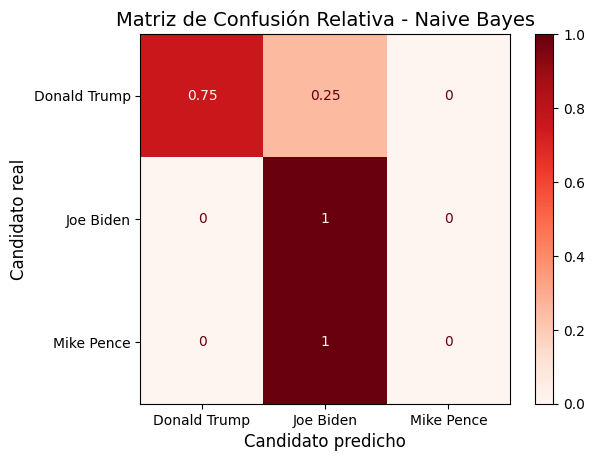

Precisión y Recall por Candidato:
      Candidato  Precision  Recall
0  Donald Trump   1.000000    0.75
1     Joe Biden   0.677419    1.00
2    Mike Pence   0.000000    0.00


c:\Users\matoi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [35]:
# MATRIZ DE CONFUSION RELATIVA

# Calcular la matriz de confusión absoluta
cm = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)

# Normalizar por fila para obtener la matriz relativa
cm_relative = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualizar la matriz de confusión relativa
disp = ConfusionMatrixDisplay(confusion_matrix=cm_relative, display_labels=nb_model.classes_)
disp.plot(cmap=plt.cm.Reds)
plt.title("Matriz de Confusión Relativa - Naive Bayes", fontsize=14)
plt.ylabel("Candidato real", fontsize=12)
plt.xlabel("Candidato predicho", fontsize=12)
plt.show()

# Calcular precision y recall por candidato
precision = precision_score(y_test, y_pred, average=None, labels=nb_model.classes_)
recall = recall_score(y_test, y_pred, average=None, labels=nb_model.classes_)

# Crear un DataFrame para mostrar los resultados
results_df = pd.DataFrame({
    'Candidato': nb_model.classes_,
    'Precision': precision,
    'Recall': recall
})
print("Precisión y Recall por Candidato:")
print(results_df)

In [43]:
def get_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

get_accuracy(y_test, y_pred)

np.float64(0.7674418604651163)

In [45]:
# 2: Implemente una búsqueda de hiperparámetros usando GridSearchCV.

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Suponiendo que:
# X_dev es el conjunto de texto original para entrenamiento/validación
# y_dev es el vector de etiquetas

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

param_grid = {
    'tfidf__stop_words': ['english'],
    'tfidf__ngram_range': [(1,2)],
    'tfidf__use_idf': [True],
    'clf__alpha': [0.001, 0.01,0.1, 1, 10],
  #  'clf__fit_prior': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_dev, y_dev)

print("Mejores parámetros:", grid_search.best_params_)
print(f"Mejor score de validación cruzada: {grid_search.best_score_:.4f}")


Mejores parámetros: {'clf__alpha': 0.001, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__use_idf': True}
Mejor score de validación cruzada: 0.9300


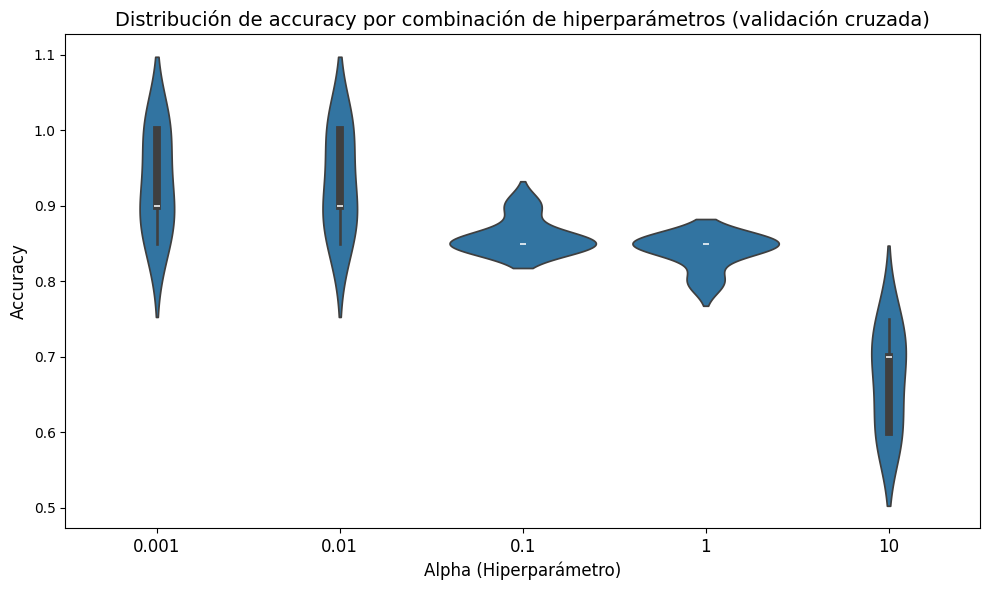

In [41]:

# Supongamos que ya tienes grid_search entrenado
# grid_search.fit(X_dev, y_dev)

results = grid_search.cv_results_

# Preparar datos para gráfico violín
data = []

for i in range(len(results['params'])):
    params_str = str(results['params'][i]['clf__alpha'])  # Parámetros en string para etiquetar
    for fold_idx in range(grid_search.cv):  # cv splits
        score = results[f'split{fold_idx}_test_score'][i]
        data.append({
            'Model': params_str,
            'Fold': fold_idx + 1,
            'Accuracy': score
        })

df = pd.DataFrame(data)

plt.figure(figsize=(10,6))
sns.violinplot(x='Model', y='Accuracy', data=df)
plt.xticks(rotation=0, fontsize=12)
plt.xlabel('Alpha (Hiperparámetro)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Distribución de accuracy por combinación de hiperparámetros (validación cruzada)', fontsize=14)
plt.tight_layout()
plt.show()


Accuracy final sobre el conjunto de test: 0.8140


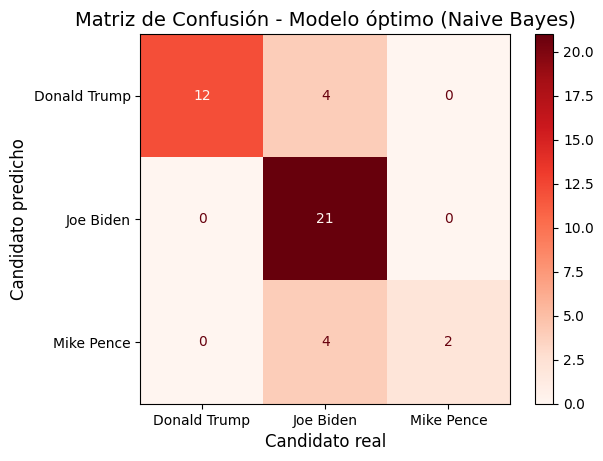

Precisión y Recall por clase:
      Candidato  Precision    Recall
0  Donald Trump   1.000000  0.750000
1     Joe Biden   0.724138  1.000000
2    Mike Pence   1.000000  0.333333


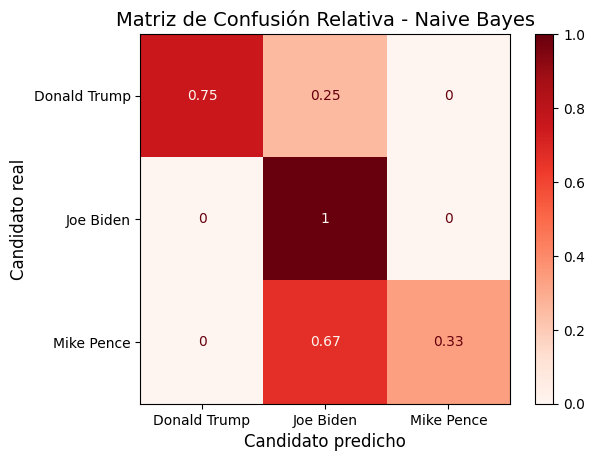

In [ ]:
# Re-entreno el modelo con los mejores parámetros encontrados en el GridSearchCV y evalúelo sobre el conjunto de test.
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd

# 1. Construir el pipeline con los mejores parámetros encontrados
best_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 2),
        use_idf=True  # Esto se aplica dentro del TfidfVectorizer directamente
    )),
    ('clf', MultinomialNB(alpha=0.001))  # Ajustar alpha según el mejor encontrado
])

# 2. Entrenar sobre TODO el conjunto de entrenamiento
best_pipeline.fit(X_dev, y_dev)

# 3. Predecir sobre el conjunto de prueba
y_pred = best_pipeline.predict(X_test)

# 4. Calcular métricas finales
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy final sobre el conjunto de test: {accuracy:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=best_pipeline.named_steps['clf'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline.named_steps['clf'].classes_)
disp.plot(cmap=plt.cm.Reds)
plt.title("Matriz de Confusión - Modelo óptimo (Naive Bayes)", fontsize=14)
plt.ylabel("Candidato predicho",fontsize=12)
plt.xlabel("Candidato real", fontsize=12)
plt.show()

# Precision y Recall por clase
precision = precision_score(y_test, y_pred, average=None, labels=best_pipeline.named_steps['clf'].classes_)
recall = recall_score(y_test, y_pred, average=None, labels=best_pipeline.named_steps['clf'].classes_)

# Mostrar resultados
results_df = pd.DataFrame({
    'Candidato': best_pipeline.named_steps['clf'].classes_,
    'Precision': precision,
    'Recall': recall
})
print("Precisión y Recall por clase:")
print(results_df)


# Normalizar por fila para obtener la matriz relativa
cm_relative =    cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualizar la matriz de confusión relativa
disp = ConfusionMatrixDisplay(confusion_matrix=cm_relative, display_labels=nb_model.classes_)
disp.plot(cmap=plt.cm.Reds)
plt.title("Matriz de Confusión Relativa - Naive Bayes", fontsize=14)
plt.ylabel("Candidato real", fontsize=12)
plt.xlabel("Candidato predicho", fontsize=12)
plt.show()

In [48]:
# 4: Evalúe con validación cruzada al menos un modelo más (dentro de scikit-learn) aparte de Multinomial Naive Bayes para clasificar el texto utilizando las mismas features de texto.

# Elegimos modelo de Regresión Logística 

# buscar el mejor modelo de regresión logística con GridSearchCV
from sklearn.linear_model import LogisticRegression
# Definir el pipeline para la regresión logística
logistic_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 2),
        use_idf=True
    )),
    ('clf', LogisticRegression(max_iter=1000))  # Aumentar max_iter para asegurar convergencia
])
# Definir la cuadrícula de hiperparámetros
param_grid_logistic = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 30, 50],  # Parámetro de regularización
    'clf__solver': ['lbfgs', 'liblinear'],  # Solvers comunes para regresión logística
}
# Realizar la búsqueda de hiperparámetros
grid_search_logistic = GridSearchCV(logistic_pipeline, param_grid_logistic, scoring='accuracy', cv=5, n_jobs=-1)
grid_search_logistic.fit(X_dev, y_dev)
print("Mejores parámetros para Regresión Logística:", grid_search_logistic.best_params_)
print(f"Mejor score de validación cruzada: {grid_search_logistic.best_score_:.4f}")

Mejores parámetros para Regresión Logística: {'clf__C': 30, 'clf__solver': 'liblinear'}
Mejor score de validación cruzada: 0.9200


c:\Users\matoi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


c:\Users\matoi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Accuracy del modelo Regresión Logística: 0.81


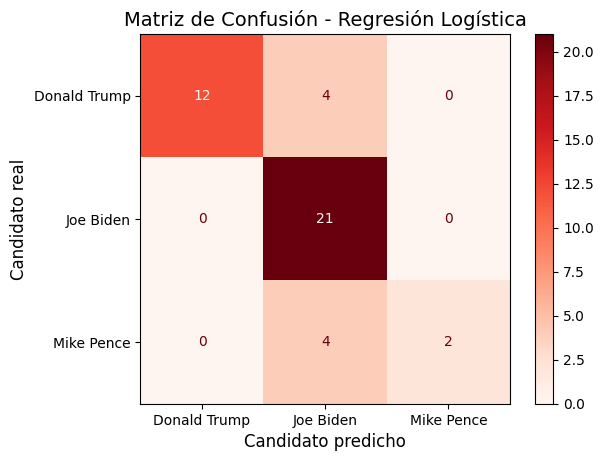

Precision y Recall por Candidato (Regresión Logística):       Candidato  Precision    Recall
0  Donald Trump   1.000000  0.750000
1     Joe Biden   0.724138  1.000000
2    Mike Pence   1.000000  0.333333


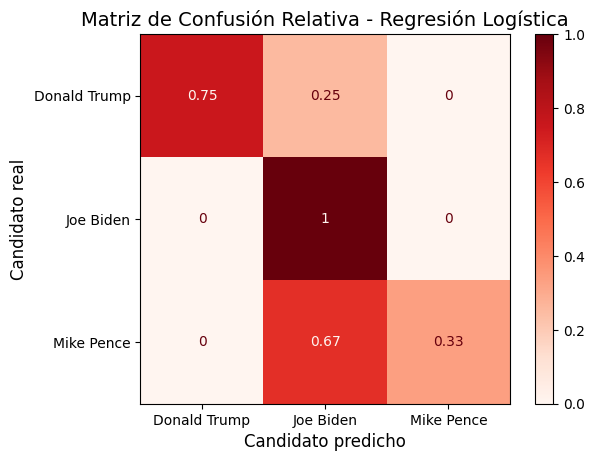

In [49]:
# 1. Construir el pipeline con los mejores parámetros encontrados
best_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 2),
        use_idf=True  # Esto se aplica dentro del TfidfVectorizer directamente
    )),
    ('clf', LogisticRegression(
        C=grid_search_logistic.best_params_['clf__C'],
        solver=grid_search_logistic.best_params_['clf__solver'],
        max_iter=1000  # Asegurar que el modelo converja
    ))
])

# 2. Entrenar sobre TODO el conjunto de entrenamiento
best_pipeline.fit(X_dev, y_dev)
y_pred_logistic = best_pipeline.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f"Accuracy del modelo Regresión Logística: {accuracy_logistic:.2f}")

# Calcular la matriz de confusión
cm_logistic = confusion_matrix(y_test, y_pred_logistic, labels=best_pipeline.classes_)
# Visualizar la matriz de confusión
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=best_pipeline.classes_)
disp_logistic.plot(cmap=plt.cm.Reds)
plt.title("Matriz de Confusión - Regresión Logística", fontsize=14)
plt.ylabel("Candidato real", fontsize=12)
plt.xlabel("Candidato predicho", fontsize=12)
plt.show()
# Calcular precision y recall para cada candidato
precision_logistic = precision_score(y_test, y_pred_logistic, average=None, labels=best_pipeline.classes_)
recall_logistic = recall_score(y_test, y_pred_logistic, average=None, labels=best_pipeline.classes_)
# Crear un DataFrame para mostrar los resultados
results_logistic_df = pd.DataFrame({
    'Candidato': best_pipeline.classes_,
    'Precision': precision_logistic,
    'Recall': recall_logistic
})
print("Precision y Recall por Candidato (Regresión Logística):", results_logistic_df)

#MATRIZ DE CONFUSION RELATIVA
# Calcular la matriz de confusión absoluta
cm_logistic = confusion_matrix(y_test, y_pred_logistic, labels=best_pipeline.classes_)
# Normalizar por fila para obtener la matriz relativa
cm_logistic_relative = cm_logistic.astype('float') / cm_logistic.sum(axis=1)[:, np.newaxis]
# Visualizar la matriz de confusión relativa
disp_logistic_relative = ConfusionMatrixDisplay(confusion_matrix=cm_logistic_relative, display_labels=best_pipeline.classes_)
disp_logistic_relative.plot(cmap=plt.cm.Reds)
plt.title("Matriz de Confusión Relativa - Regresión Logística", fontsize=14)
plt.ylabel("Candidato real", fontsize=12)
plt.xlabel("Candidato predicho", fontsize=12)
plt.show()






In [ ]:
# 5: Evalúe el problema cambiando al menos un candidato. En particular, observe el (des)balance de datos y los problemas que pueda generar, así como cualquier indicio que pueda ver en el mapeo previo con PCA.
# Me quedo con los tres candidatos que me interesan y procedo a hacer la limpieza del texto.

# SE REPITE EL PROCESO PERO ESTA VEZ CON LOS CANDIDATOS: Mike Pence, Joe Biden y Bernie Sanders.

# Realizar la limpieza de los datos que crea pertinente. Se espera que usen la función clean_text() de la entrega anterior.
# Tome los discursos de Trump, Biden y Sanders
df_speeches_another_3 = df_speeches[df_speeches['speaker'].isin(['Mike Pence', 'Joe Biden', 'Bernie Sanders'])] # Analizo el número de apariciones de cada candidato en mi DataFrame y me quedo con el top 5.
# Verificar el número de discursos por candidato
df_speeches_another_3_counts = df_speeches_another_3['speaker'].value_counts()
print("Número de discursos por candidato (Trump, Biden, Sanders):")
print(df_speeches_another_3_counts)

# DataFrame con los datos de los 3 candidatos con más discursos
df_speeches_another_3_df = pd.DataFrame(df_speeches_another_3) #Creo un DataFrame que posea únicamente los discursos de los 5 candidatos con más discursos.

# En los discursos se observa la presencia de diálogos entre los candidatos y agentes externos (entevistadores, multitudes, etc.) Dado que únicamente interesa lo que 
# efectivamente dice el candidato, se eliminará todo lo no dicho por él, así como todas las estampas de tiempo que correspondientes a las transcripciones.

#Dentro de los discursos, y en sus transcripciones, a los candidatos se los menciona de distintas formas. Nos interesa quedarnos con todo lo que dice el candidato, sea como sea 
# que se lo nombre. 
aliases = {
    "Donald Trump": ["Donald Trump", "President Trump", "Mr. Trump", "President Donald J. Trump"],
    "Joe Biden": ["Joe Biden", "President Biden", "Mr. Biden"],
    "Mike Pence": ["Mike Pence", "Vice President Pence", "Mr. Pence"],
    "Kamala Harris": ["Kamala Harris", "Senator Harris", "Mrs. Harris"],
    "Bernie Sanders": ["Bernie Sanders", "Senator Sanders", "Mr. Sanders"]
}

def extract_candidate_speech(text, candidate):
    valid_aliases = aliases.get(candidate, [])

    # Captura encabezados como "Nombre del candidato: (HH:MM:SS)" o "(MM:SS)"
    pattern = re.compile(r"^(.*?):\s*\((\d{1,2}:)?\d{1,2}:\d{2}\)\s*\n", re.MULTILINE)

    matches = list(pattern.finditer(text))  # busco todas las coincidencias de pattern en el texto. finditer analiza el texto buscando las coincidencias y devuelve la posición en el texto donde se encuentra el pattern.
    speeches = []

    for i, match in enumerate(matches):  #Itero en todas las coincidencias
        speaker = match.group(1).strip() # Devuelve la persona que habla (candidato o audiencia o cualquier otra persona que habló.)
        start = match.end() #Devuelve el índice del primer caracter posterior al pattern. 
        end = matches[i + 1].start() if i + 1 < len(matches) else len(text) #Devuelve el índice del primer caracter previo al sigueinte pattern.
        speech_text = text[start:end].strip()  #Se queda con el texto de los discursos (todo lo posterior a los encabezados)
        
        if speaker in valid_aliases: # A partir de aqui me quedo solo con el texto de los candidatos.
            # Elimina etiquetas como [inaudible 00:06:17], [crosstalk 01:02:33], etc.
            clean_speech = re.sub(r"\[[^\]]*\d{1,2}:\d{2}(?::\d{2})?\]", "", speech_text) # Quito ciertas estructuras con la función re.sub()
            speeches.append(clean_speech.strip())

    return "\n".join(speeches) # Devuelvo las partes del discurso dichas por el candidato, separadas por párrafos (\n).

# Aplicamos la limpieza de partes del discurso que no nos interesan. La aplicación se hace sobre cada fila del DataFrame.
df_speeches_another_3_df["pre_processed_text"] = df_speeches_another_3_df.apply(
    lambda row: extract_candidate_speech(row["text"], row["speaker"]),
    axis=1
)



def expand_contractions(text):
    contractions = {
        r"\bcan’t\b": "cannot",   #con el r indico que es una cadena cruda, por ende el \b me separa la palabra can't de otras palabras que la contengan.
        r"\bwon’t\b": "will not",
        r"\bit’s\b": "it is",
        r"\bi’m\b": "i am",
        r"\bi’ve\b": "i have",
        r"\bi’d\b": "i would",
        r"\bi’ll\b": "i will",
        r"\byou’re\b": "you are",
        r"\byou’ve\b": "you have",
        r"\byou’d\b": "you would",
        r"\byou’ll\b": "you will",
        r"\bhe’s\b": "he is",
        r"\bshe’s\b": "she is",
        r"\bthey’re\b": "they are",
        r"\bwe’re\b": "we are",
        r"\bdon’t\b": "do not",
        r"\bdidn’t\b": "did not",
        r"\bdoesn’t\b": "does not",
        r"\bwasn’t\b": "was not",
        r"\bweren’t\b": "were not",
        r"\bcouldn’t\b": "could not",
        r"\bshouldn’t\b": "should not",
        r"\bwouldn’t\b": "would not",
        r"\bthat’s\b": "that is",
        r"\bthere’s\b": "there is",
        r"\bwhat’s\b": "what is",
        r"\bwho’s\b": "who is",
        r"\blet’s\b": "let us",
        r"\bisn’t\b": "is not",
        r"\baren’t\b": "are not",
        r"\bgonna\b": "going to",
        r"\bwanna\b": "want to",
        r"\bgotta\b": "got to"
    }
    for pattern, repl in contractions.items():
        text = re.sub(pattern, repl, text)
    return text

def clean_text(df, column_name):
    
    # Eliminar primeras palabras hasta el primer "\n"
    result = df[column_name].str.replace(r"^[^\n]*\n", "", regex=True)
    
    # Convertir todo a minúsculas
    result = result.str.lower()
    
    # Expandir contracciones
    result = result.apply(expand_contractions)

    # Reemplazar signos de puntuación faltantes
    for punc in ["[", "]", "\n", ",", ":", "?", "(", ")", "!", ".", "...",";", "¿", "¡", "“", "”", '"', "'", "‘", "’", "{", "}", "%","$","0","1","-","/","2","22","3","4","5","6","7","8","9"]: # agregue: "%" "(", ")", "!", ".", ";", "¿", "¡", "“", "”", '"', "'", "‘", "’", "{", "}"
        result = result.str.replace(punc, " ")

    # Reemplazar saltos de línea por espacios (por si quedaron después del paso 1)
    result = result.str.replace(r"\n", " ", regex=True)

    # Eliminar múltiples espacios con uno solo (normaliza frases)
    result = result.str.replace(r"\s+", " ", regex=True)

    # Eliminar espacios al inicio o final
    result = result.str.strip()

    return result

# Crear una nueva columna CleanText a partir de 'text'
df_speeches_another_3_df.loc[:, "CleanText"] = clean_text(df_speeches_another_3_df, "pre_processed_text")
df_speeches_another_3_df.loc[:, "CleanText"]


Número de discursos por candidato (Trump, Biden, Sanders):
speaker
Joe Biden         71
Mike Pence        19
Bernie Sanders    16
Name: count, dtype: int64


1      there is not a better governor in the united s...
3      okay i know it well well first of all going ba...
6      i will give it to the president today well hel...
8      and while you are at it president trump and i ...
9      look you are an inspiration man i really mean ...
                             ...                        
245    oh bless me father for i have sinned anyway lo...
248    i am guessing about a month ago well it was no...
254    now look going on too much let me conclude and...
260    let me thank samantha valenti let me thank ele...
264    and one word if i might about the so called st...
Name: CleanText, Length: 106, dtype: object

In [71]:
# 1: Separar 30% del conjunto para test. Al resto lo llamamos "dev" (desarrollo).
X = df_speeches_another_3_df["CleanText"].to_numpy()  #Hay 143 discursos de los 3 candidatos con más discursos.
y = df_speeches_another_3_df["speaker"].to_numpy()

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)  # stratify=y asegura que la proporción de clases se mantenga en ambos conjuntos.

print(f"Tamaños de los conjuntos: {X_dev.shape}, {X_test.shape}")

Tamaños de los conjuntos: (74,), (32,)


Dimensiones de X_dev_counts: (100, 10905)
Dimensiones de X_dev_tfidf: (74, 14740)
Primeros 5 términos del vocabulario: ['abandoned' 'aberration' 'abide' 'ability' 'ability able']
Dimensiones de X_dev_pca: (74, 2)


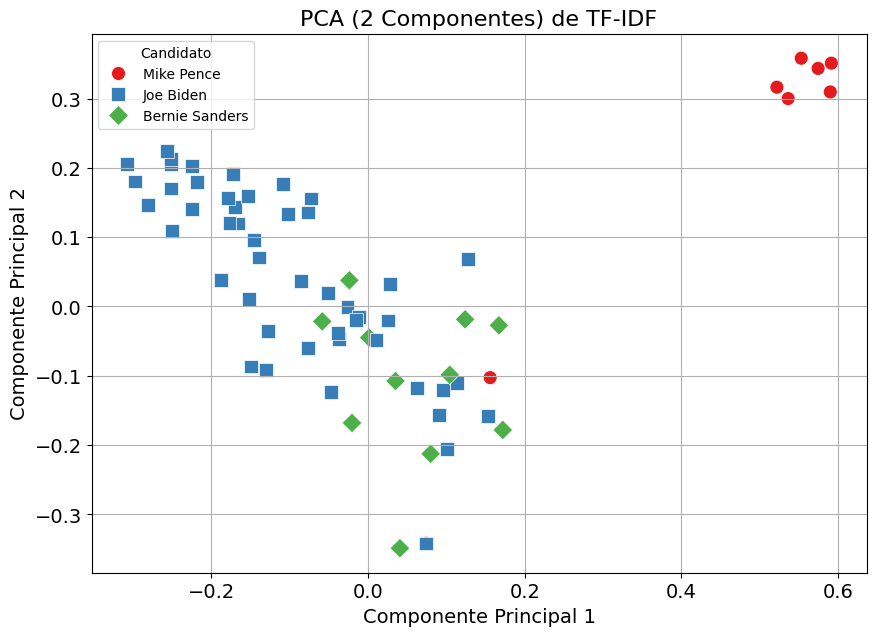

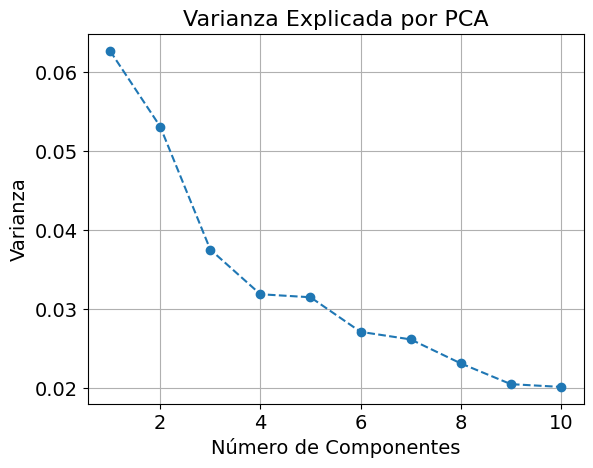

In [76]:
####### AFINO EL ANÁLISIS SACANDO STOPWORDS Y CON IDF VERDADERO #######

# 3: Transforme el texto del conjunto de entrenamiento a la representación numérica (features) de conteo de palabras o bag of words.
# Crear el vectorizador de conteo
vectorizer_4 = CountVectorizer(stop_words="english", ngram_range=(1, 2), min_df=2)
# Ajustar y transformar el conjunto de entrenamiento
X_dev_counts_3 = vectorizer_4.fit_transform(X_dev)
# Transformar el conjunto de prueba
X_test_counts_3 = vectorizer_4.transform(X_test) #La salida es una matriz dispersa (sparse matrix) que representa la frecuencia de palabras en los discursos de los candidatos.
# Verificar las dimensiones de la matriz de características
print(f"Dimensiones de X_dev_counts: {X_dev_counts.shape}")


# 4: Obtenga la representación numérica Term Frequency - Inverse Document Frequency.
# Crear el transformador TF-IDF: PONGO IDF=TRUE
tfidf_transformer_3 = TfidfTransformer(use_idf=True)  # use_idf=True indica que se utilizará el IDF en el cálculo del TF-IDF
# Ajustar y transformar el conjunto de entrenamiento
X_dev_tfidf_3 = tfidf_transformer_3.fit_transform(X_dev_counts_3)
# Transformar el conjunto de prueba
X_test_tfidf_3 = tfidf_transformer_3.transform(X_test_counts_3)
# Verificar las dimensiones de la matriz TF-IDF
print(f"Dimensiones de X_dev_tfidf: {X_dev_tfidf_3.shape}")
# Visualizar los primeros 5 términos del vocabulario
print("Primeros 5 términos del vocabulario:", vectorizer_4.get_feature_names_out()[:5])



# 5 :Muestre en un mapa el conjunto de entrenamiento, utilizando las dos primeras componentes PCA sobre los vectores de tf-idf.
# Aplicar PCA para reducir la dimensionalidad a 2 componentes---PRIMERA ITERACION: IDF VERDADER Y SIN STOPWORDS
pca = PCA(n_components=2)
X_dev_pca_3 = pca.fit_transform(X_dev_tfidf_3.toarray())  # Convertimos la matriz dispersa a un array denso para PCA
# Verificar las dimensiones de la matriz PCA
print(f"Dimensiones de X_dev_pca: {X_dev_pca_3.shape}")
# Crear un DataFrame para facilitar la visualización
df_pca_3 = pd.DataFrame(X_dev_pca_3, columns=['Component 1', 'Component 2'])
# Agregar la columna de etiquetas
df_pca_3['Speaker'] = y_dev
# Visualizar los datos en un mapa de dispersión
# Crear DataFrame para graficar
df_plot_3 = pd.DataFrame({
    'PC1': X_dev_pca_3[:, 0],
    'PC2': X_dev_pca_3[:, 1],
    'Candidato': df_pca_3["Speaker"]
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot_3, x="PC1", y="PC2", hue="Candidato", palette="Set1", style="Candidato", markers=["o", "s", "D"], s=100, edgecolor='w', linewidth=0.5)
plt.title("PCA (2 Componentes) de TF-IDF",fontsize=16)
plt.xlabel("Componente Principal 1",fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.ylabel("Componente Principal 2",fontsize=14)
plt.grid(True)
plt.show()

# Guardar la figura antes de mostrarla

# Haga una visualización que permita entender cómo varía la varianza explicada a medida que se agregan componentes (e.g: hasta 10 componentes).

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_dev_tfidf_3.toarray())

plt.plot(range(1, 11), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel("Número de Componentes",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Varianza",fontsize=14)
plt.title("Varianza Explicada por PCA",fontsize=16)
plt.grid(True)
plt.show()



Accuracy final sobre el conjunto de test: 0.6562


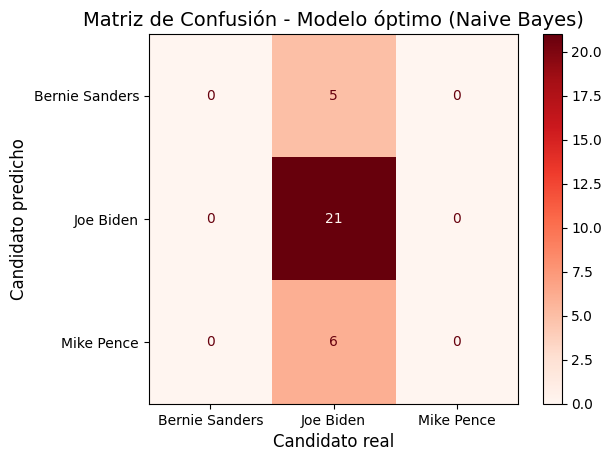

Precisión y Recall por clase:
        Candidato  Precision  Recall
0  Bernie Sanders    0.00000     0.0
1       Joe Biden    0.65625     1.0
2      Mike Pence    0.00000     0.0


c:\Users\PC\OneDrive\Documentos\FIng\Maestría\Intro CD\intro-cd\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


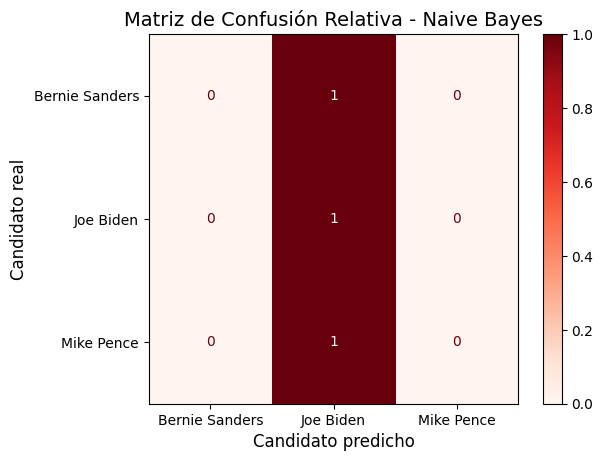

In [81]:
# Aplico el MMB para el caso de los datos con los candidatos que me intersan

# 1. Construir el pipeline con los mejores parámetros encontrados
best_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 1),
        use_idf=True  # Esto se aplica dentro del TfidfVectorizer directamente
    )),
    ('clf', MultinomialNB(alpha=1))  # Ajustar alpha según el mejor encontrado
])

# 2. Entrenar sobre TODO el conjunto de entrenamiento
best_pipeline.fit(X_dev, y_dev)

# 3. Predecir sobre el conjunto de prueba
y_pred = best_pipeline.predict(X_test)

# 4. Calcular métricas finales
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy final sobre el conjunto de test: {accuracy:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=best_pipeline.named_steps['clf'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline.named_steps['clf'].classes_)
disp.plot(cmap=plt.cm.Reds)
plt.title("Matriz de Confusión - Modelo óptimo (Naive Bayes)", fontsize=14)
plt.ylabel("Candidato predicho",fontsize=12)
plt.xlabel("Candidato real", fontsize=12)
plt.show()

# Precision y Recall por clase
precision = precision_score(y_test, y_pred, average=None, labels=best_pipeline.named_steps['clf'].classes_)
recall = recall_score(y_test, y_pred, average=None, labels=best_pipeline.named_steps['clf'].classes_)

# Mostrar resultados
results_df = pd.DataFrame({
    'Candidato': best_pipeline.named_steps['clf'].classes_,
    'Precision': precision,
    'Recall': recall
})
print("Precisión y Recall por clase:")
print(results_df)


# Normalizar por fila para obtener la matriz relativa
cm_relative =    cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualizar la matriz de confusión relativa
disp = ConfusionMatrixDisplay(confusion_matrix=cm_relative, display_labels=best_pipeline.named_steps['clf'].classes_)
disp.plot(cmap=plt.cm.Reds)
plt.title("Matriz de Confusión Relativa - Naive Bayes", fontsize=14)
plt.ylabel("Candidato real", fontsize=12)
plt.xlabel("Candidato predicho", fontsize=12)
plt.show()